# 5-Fold Cross-Validation for InceptionTime with standing-walking as background

Standing and walking are merged into an even bigger majority class `background`, since walking is not easy to detect after normalization.

In [1]:
import tsai
from tsai.all import *
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score, classification_report

from winkie import ts_prep

# Load and perpare data

In [2]:
df = pd.read_hdf("merged_20210405.h5")
df.loc[(df['behavior'] == "back_preening") | (df['behavior'] == "front_preening"), 'behavior'] = "preening"
df.loc[(df['behavior'] == "standing_shaking") | (df['behavior'] == "scratch_with_feet"), 'behavior'] = "standing"
df.loc[(df['behavior'] == "body_pump") | (df['behavior'] == "feather_clapping"), 'behavior'] = "fluffing"
df = df[(df['behavior'] != "not_defined")]
df.loc[(df['behavior'] == "standing") | (df['behavior'] == "walking" ), 'behavior'] = "background"


# 16 frames sliding window

In [6]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

X, y = SlidingWindow(16, get_x=features, get_y='behavior', y_func=y_func)(df)

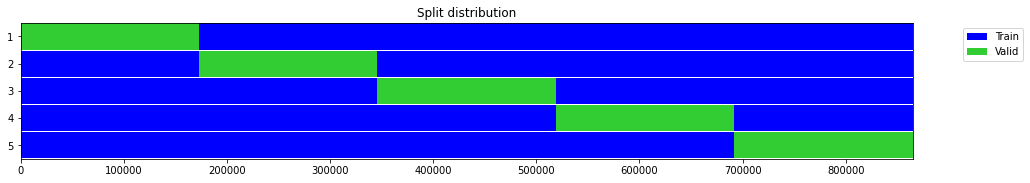

In [7]:
splits = get_splits(y, n_splits=5, shuffle=False, stratify=True, check_splits=True)
tfms  = [None, [Categorize()]]

In [8]:
def train_and_evaluate_it(X, y, splits, bs, lr, epochs):
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
    
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    #lr_min,lr_steep = learn.lr_find(suggestions=True)
    #print(f"Minimum/10: {lr_min}, steepest point: {lr_steep}")
    #print(f"Using LR: {lr}")
    learn.fit_one_cycle(epochs, lr_max=lr)
    learn.recorder.plot_metrics()
    
    dls = learn.dls
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    cat_ac = (valid_targets == valid_preds).float().mean()
    print(cat_ac)
    print(roc_auc_score(valid_targets, valid_probas, multi_class='ovo', average='macro'))
    print(classification_report(valid_preds, valid_targets))
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(normalize=True, figsize=(10, 10))
    interp.plot_confusion_matrix(figsize=(10, 10))

===================== Fold 0 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.112601,0.451069,0.932377,01:09
1,0.062353,0.659974,0.893742,01:04
2,0.032382,0.680291,0.925965,01:04
3,0.013747,0.790556,0.877140,01:04
4,0.008467,0.791973,0.897514,01:04


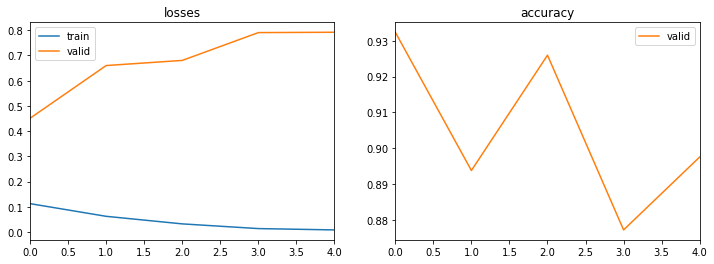

TensorCategory(0.8975)
0.8743337732201711
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     72045
           1       0.93      0.97      0.95     91271
           2       0.49      0.22      0.31       610
           3       0.32      0.66      0.43       335
           4       0.54      0.25      0.34      8709
           5       0.65      0.75      0.70       137

    accuracy                           0.90    173107
   macro avg       0.64      0.63      0.60    173107
weighted avg       0.89      0.90      0.89    173107



===================== Fold 1 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.106210,0.562179,0.819672,01:05
1,0.060577,0.431727,0.890004,01:05
2,0.029750,0.561090,0.861912,01:06
3,0.015023,0.630559,0.867781,01:04
4,0.009329,0.647085,0.872911,01:05


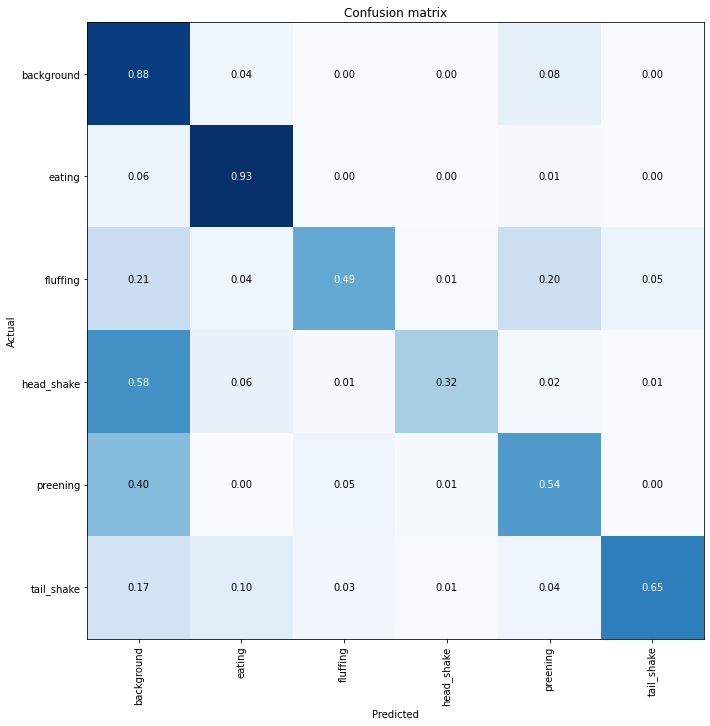

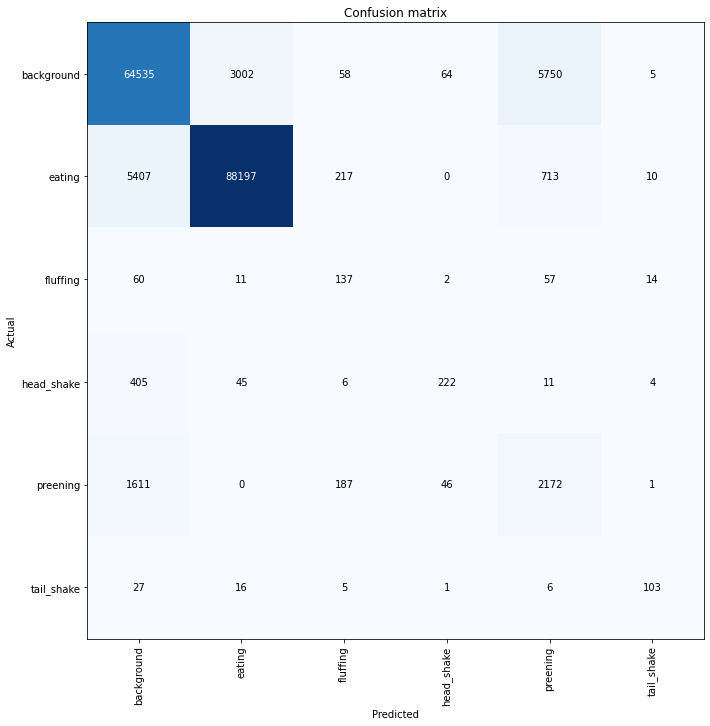

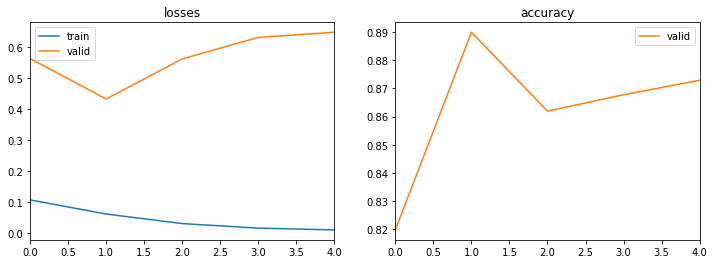

TensorCategory(0.8729)
0.9242290437652507
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     64392
           1       0.92      0.97      0.95     74500
           2       0.77      0.24      0.37      9807
           3       0.49      0.57      0.52      1504
           4       0.76      0.74      0.75     21754
           5       0.52      0.59      0.55      1150

    accuracy                           0.87    173107
   macro avg       0.72      0.67      0.67    173107
weighted avg       0.87      0.87      0.86    173107



===================== Fold 2 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.107658,0.760845,0.721211,01:04
1,0.058986,0.475259,0.889443,01:04
2,0.031045,1.201553,0.735671,01:05
3,0.015063,1.636632,0.730899,01:04
4,0.010747,1.346287,0.736110,01:04


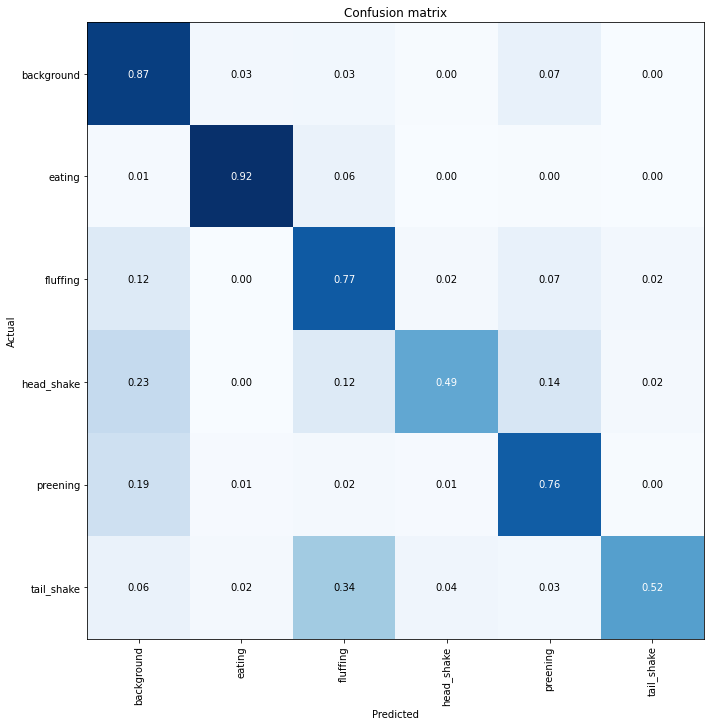

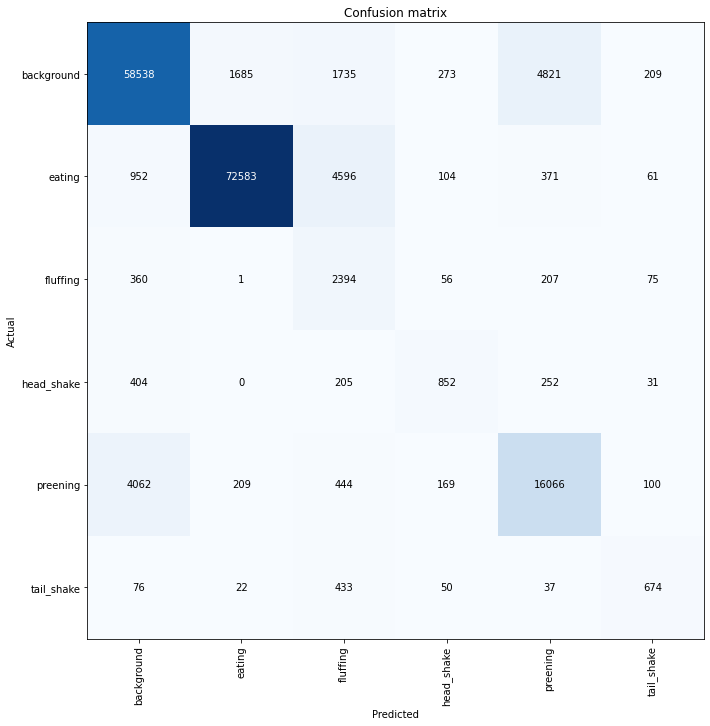

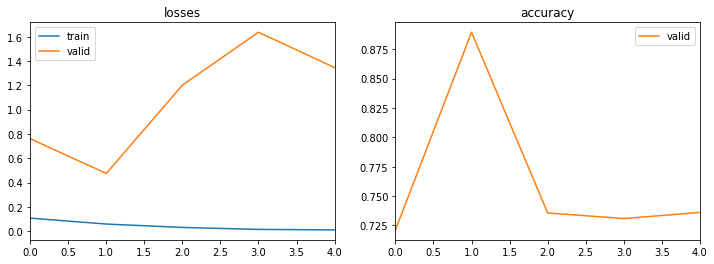

TensorCategory(0.7361)
0.8759667006237317
              precision    recall  f1-score   support

           0       0.55      0.85      0.66     47232
           1       0.97      0.99      0.98     64226
           2       0.69      0.59      0.64      8335
           3       0.26      0.41      0.32      1976
           4       0.76      0.34      0.47     48554
           5       0.64      0.63      0.64      2783

    accuracy                           0.74    173106
   macro avg       0.65      0.63      0.62    173106
weighted avg       0.77      0.74      0.72    173106



===================== Fold 3 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.107819,0.314007,0.912770,01:04
1,0.056189,0.355963,0.923059,01:05
2,0.032191,0.358381,0.928113,01:05
3,0.015213,0.400958,0.927270,01:05
4,0.010209,0.425696,0.927149,01:05


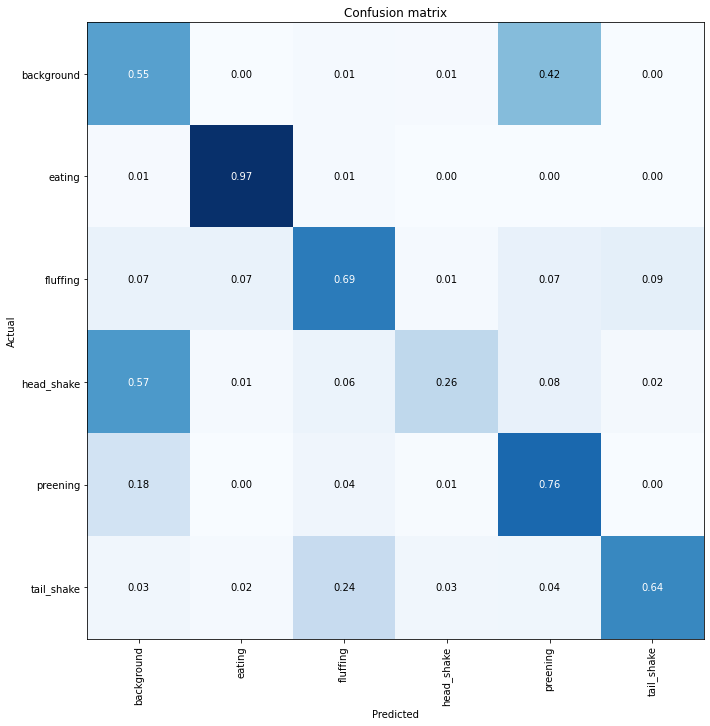

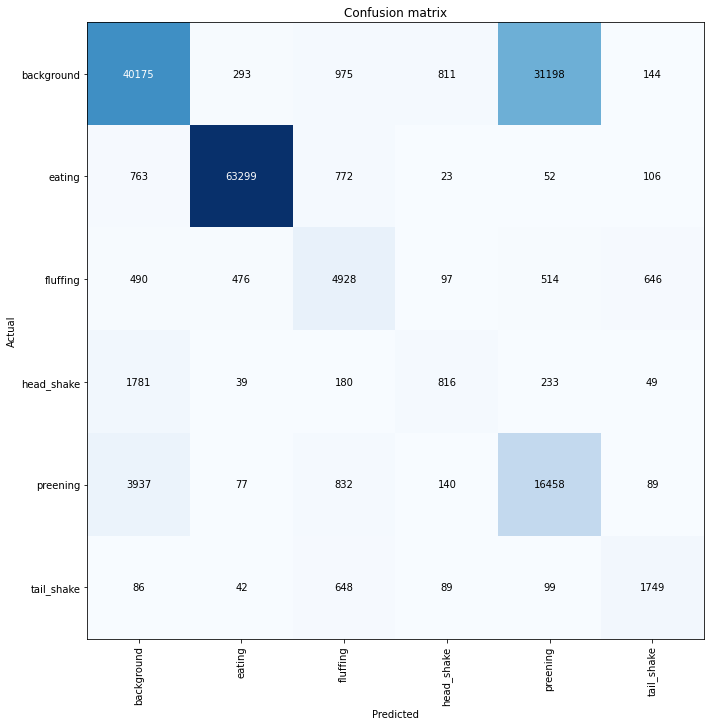

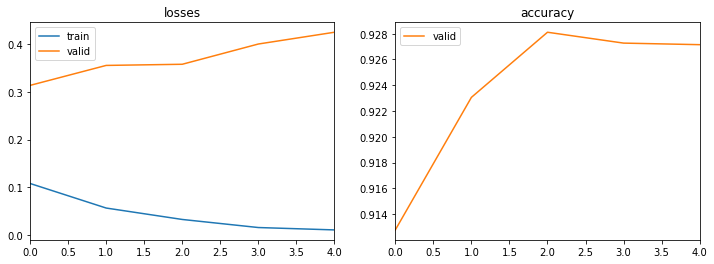

TensorCategory(0.9271)
0.9027985325652044
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    105632
           1       0.98      0.98      0.98     52778
           2       0.69      0.83      0.75      4467
           3       0.56      0.42      0.48      2176
           4       0.50      0.64      0.56      7250
           5       0.52      0.45      0.48       803

    accuracy                           0.93    173106
   macro avg       0.70      0.71      0.70    173106
weighted avg       0.93      0.93      0.93    173106



===================== Fold 4 ============================


epoch,train_loss,valid_loss,accuracy,time
0,0.113717,0.342878,0.892280,01:05
1,0.060758,0.296363,0.927241,01:05
2,0.032172,0.336895,0.926773,01:04
3,0.016138,0.387681,0.924191,01:05
4,0.010181,0.418709,0.923209,01:05


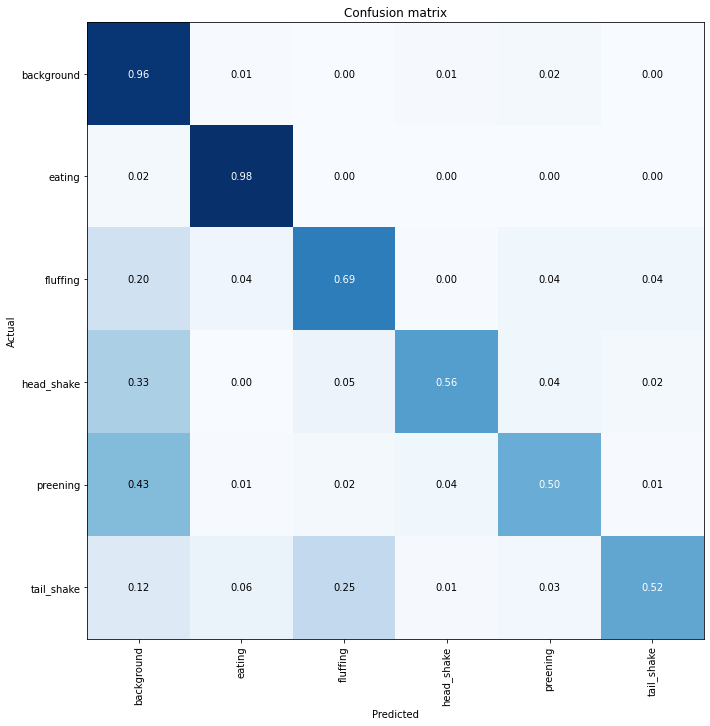

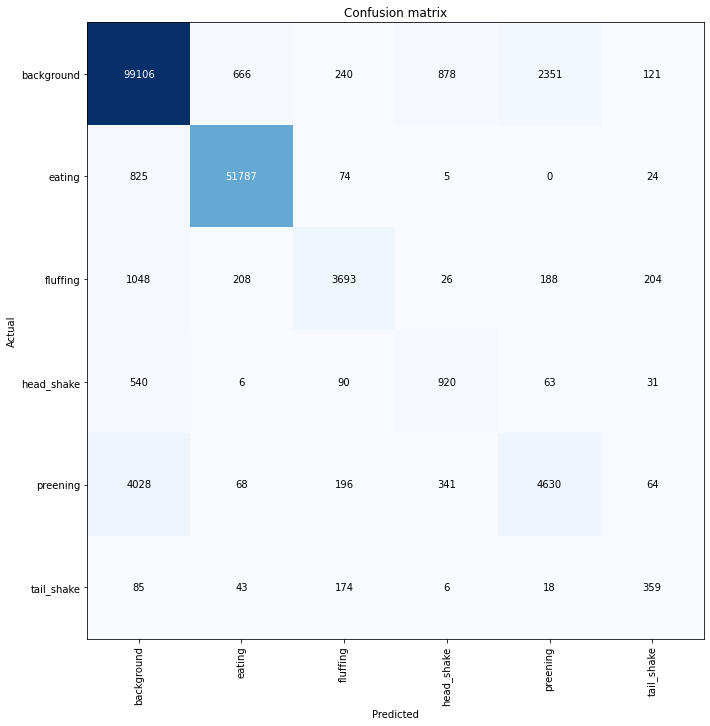

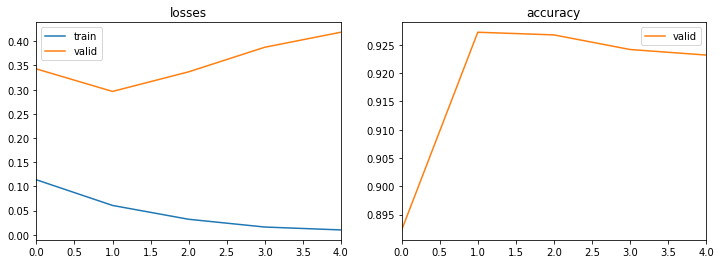

TensorCategory(0.9232)
0.9316826744317143
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     83966
           1       0.98      0.99      0.98     65839
           2       0.69      0.89      0.78      9204
           3       0.50      0.35      0.41      2217
           4       0.74      0.67      0.70      9780
           5       0.61      0.51      0.55      2100

    accuracy                           0.92    173106
   macro avg       0.74      0.72      0.73    173106
weighted avg       0.92      0.92      0.92    173106



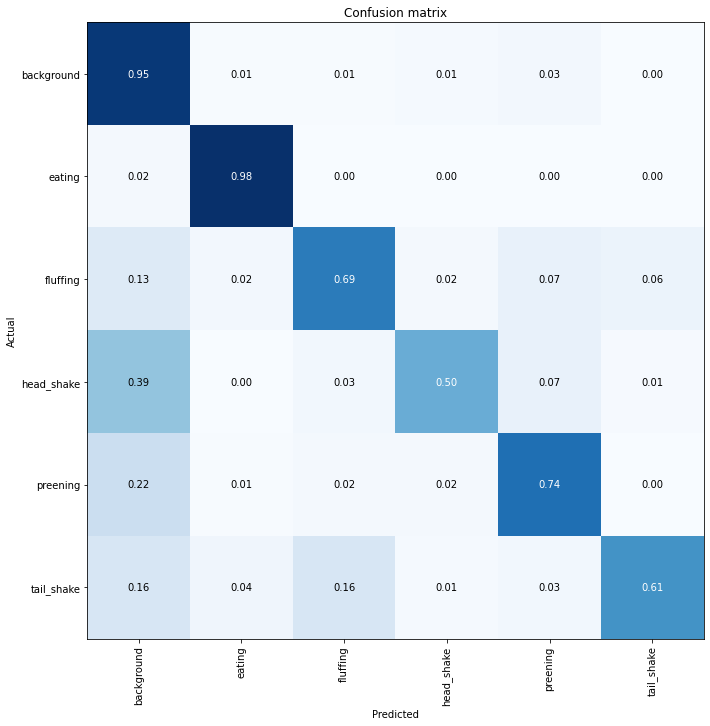

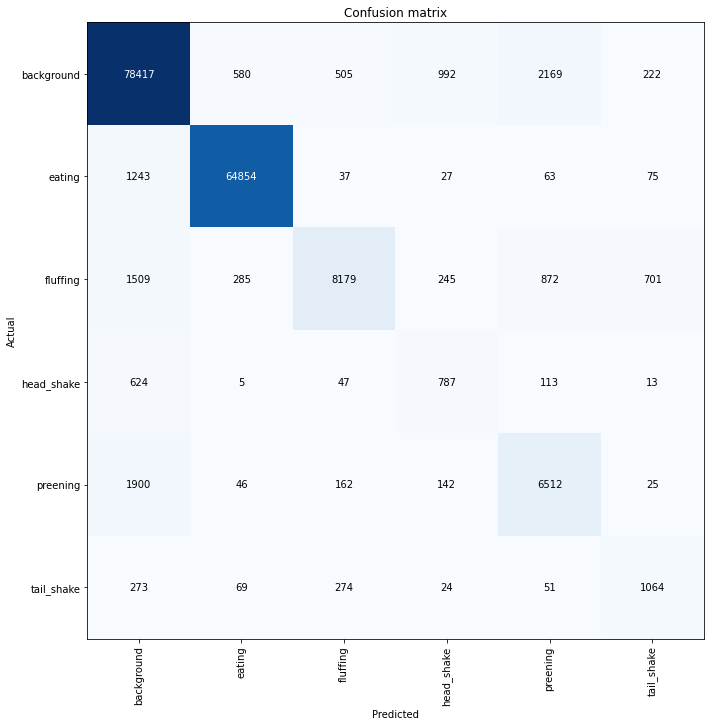

In [9]:
for i, s in enumerate(splits):
    print(f'===================== Fold {i} ============================')
    train_and_evaluate_it(X, y, s, 512, 0.001, 5)

Since the performance seems worse when looking at the individual behaviours and we are creating a bigger imbalance, we decided to not further pursue this.